# Modelos NLP para Analisis de Sentimiento

## Objetivos
1. **Comparar modelos**: TF-IDF + Logistic Regression vs TF-IDF + Linear SVM
2. **Evaluar aproximaciones**: Modelos separados por idioma vs modelo unificado
3. **Validar con corpus anotado**: Usar el corpus de test para ES
4. **Seleccionar mejor modelo**: Basado en metricas de clasificacion

## Datasets
- **Yelp**: Ingles (stars 1-5)
- **ES**: Espanol (stars 1-5)
- **Olist**: Portugues (review_score 1-5)

## Estrategia de Etiquetado
- **Positive**: stars >= 4
- **Neutral**: stars == 3
- **Negative**: stars <= 2

---

In [1]:
# Setup e imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

def find_project_root() -> Path:
    """Busca la raiz del proyecto (donde esta pyproject.toml)."""
    notebook_dir = Path.cwd()
    for parent in [notebook_dir] + list(notebook_dir.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    if notebook_dir.name == "notebooks":
        return notebook_dir.parent
    return notebook_dir

project_root = find_project_root()
sys.path.insert(0, str(project_root / "src"))

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any, Optional
import time
import re
import unicodedata

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# Config
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette('husl')

from tfm.config.settings import get_settings, BRONZE_FILES, SILVER_FILES, PROJECT_ROOT

settings = get_settings()
print(f"Project root: {PROJECT_ROOT}")
print(f"Silver dir: {settings.silver_dir}")

Project root: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents
Silver dir: C:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\data\silver


## 1. Carga de Datos

In [2]:
# Configuracion de muestras
SAMPLE_SIZES = {
    'yelp': 50000,
    'es': 50000,
    'olist': 50000
}

def load_dataset(dataset_name: str, sample_size: int = None) -> pl.DataFrame:
    """Carga un dataset desde silver o bronze."""
    
    if dataset_name == 'yelp':
        silver_path = settings.silver_dir / SILVER_FILES.get('yelp_reviews', 'yelp_reviews.parquet')
        if silver_path.exists():
            df = pl.read_parquet(silver_path)
            print(f"[YELP] Cargado desde silver: {df.height:,} registros")
        else:
            bronze_path = settings.yelp_bronze_dir / BRONZE_FILES['yelp']['reviews']
            df = pl.read_json(bronze_path)
            print(f"[YELP] Cargado desde bronze: {df.height:,} registros")
        
        # Normalizar columnas
        if 'text' not in df.columns and 'review_text' in df.columns:
            df = df.rename({'review_text': 'text'})
        
    elif dataset_name == 'es':
        silver_path = settings.silver_dir / SILVER_FILES.get('es', 'es_reviews.parquet')
        if silver_path.exists():
            df = pl.read_parquet(silver_path)
            print(f"[ES] Cargado desde silver: {df.height:,} registros")
        else:
            bronze_path = settings.es_bronze_dir / BRONZE_FILES['es']['reviews']
            try:
                df = pl.read_csv(bronze_path)
            except:
                df = pl.read_csv(bronze_path, encoding='latin1')
            print(f"[ES] Cargado desde bronze: {df.height:,} registros")
        
        # Normalizar columnas
        if 'text' not in df.columns and 'review_body' in df.columns:
            df = df.rename({'review_body': 'text'})
            
    elif dataset_name == 'olist':
        silver_path = settings.silver_dir / SILVER_FILES.get('olist_reviews', 'olist_reviews.parquet')
        if silver_path.exists():
            df = pl.read_parquet(silver_path)
            print(f"[OLIST] Cargado desde silver: {df.height:,} registros")
        else:
            bronze_path = settings.olist_bronze_dir / 'olist_order_reviews_dataset.csv'
            df = pl.read_csv(bronze_path)
            print(f"[OLIST] Cargado desde bronze: {df.height:,} registros")
        
        # Normalizar columnas
        if 'text' not in df.columns:
            if 'review_comment_message' in df.columns:
                df = df.rename({'review_comment_message': 'text'})
            elif 'comment' in df.columns:
                df = df.rename({'comment': 'text'})
        if 'stars' not in df.columns and 'review_score' in df.columns:
            df = df.rename({'review_score': 'stars'})
    else:
        raise ValueError(f"Dataset no soportado: {dataset_name}")
    
    # Aplicar sample si es necesario
    if sample_size and df.height > sample_size:
        df = df.sample(n=sample_size, seed=42)
        print(f"[{dataset_name.upper()}] Muestra reducida a: {df.height:,} registros")
    
    return df

In [3]:
# Cargar datasets
print("Cargando datasets...\n")

df_yelp = load_dataset('yelp', SAMPLE_SIZES['yelp'])
print(f"  Columnas: {df_yelp.columns}\n")

df_es = load_dataset('es', SAMPLE_SIZES['es'])
print(f"  Columnas: {df_es.columns}\n")

df_olist = load_dataset('olist', SAMPLE_SIZES['olist'])
print(f"  Columnas: {df_olist.columns}\n")

Cargando datasets...

[YELP] Cargado desde silver: 500,000 registros
[YELP] Muestra reducida a: 50,000 registros
  Columnas: ['review_id', 'user_id', 'business_id', 'stars', 'text', 'text_length', 'word_count', 'useful', 'funny', 'cool', 'date', 'year', 'month', 'is_ambiguous', 'language']

[ES] Cargado desde bronze: 210,000 registros
[ES] Muestra reducida a: 50,000 registros
  Columnas: ['review_id', 'product_id', 'reviewer_id', 'stars', 'text', 'review_title', 'language', 'product_category']

[OLIST] Cargado desde silver: 99,224 registros
[OLIST] Muestra reducida a: 50,000 registros
  Columnas: ['review_id', 'order_id', 'stars', 'text', 'text_length', 'word_count', 'has_comment', 'is_ambiguous', 'language', 'review_creation_date', 'review_answer_timestamp']



## 2. Preprocesamiento de Texto

In [ ]:
def clean_text(text: str) -> str:
    """Limpieza basica de texto multi-idioma."""
    if text is None or not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remover URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remover emails
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remover numeros aislados
    text = re.sub(r'\b\d+\b', '', text)
    
    # Remover caracteres especiales (mantener acentos)
    text = re.sub(r'[^a-zA-Z\s\u00C0-\u017F]', ' ', text)
    
    # Remover espacios multiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def stars_to_sentiment(stars: int) -> str:
    """Convierte estrellas a etiqueta de sentimiento."""
    if stars >= 4:
        return 'positive'
    elif stars <= 2:
        return 'negative'
    else:
        return 'neutral'

def prepare_dataset(df: pl.DataFrame, dataset_name: str) -> pd.DataFrame:
    """Prepara un dataset para entrenamiento."""
    # Convertir a pandas para sklearn
    pdf = df.to_pandas()
    
    # Identificar columnas
    text_col = 'text'
    stars_col = 'stars'
    
    # Filtrar filas con texto valido
    pdf = pdf[pdf[text_col].notna()]
    pdf = pdf[pdf[text_col].str.len() > 10]
    
    # Limpiar texto
    pdf['text_clean'] = pdf[text_col].apply(clean_text)
    pdf = pdf[pdf['text_clean'].str.len() > 5]
    
    # Crear etiquetas de sentimiento
    pdf['sentiment'] = pdf[stars_col].apply(stars_to_sentiment)
    
    # Agregar columna de dataset
    pdf['dataset'] = dataset_name
    
    print(f"[{dataset_name.upper()}] Preparado: {len(pdf):,} registros validos")
    print(f"  Distribucion: {pdf['sentiment'].value_counts().to_dict()}")
    
    return pdf[['text_clean', 'sentiment', 'dataset', stars_col]].copy()

In [5]:
# Preparar datasets
print("Preparando datasets para entrenamiento...\n")

pdf_yelp = prepare_dataset(df_yelp, 'yelp')
pdf_es = prepare_dataset(df_es, 'es')
pdf_olist = prepare_dataset(df_olist, 'olist')

print(f"\nTotal registros preparados:")
print(f"  Yelp: {len(pdf_yelp):,}")
print(f"  ES: {len(pdf_es):,}")
print(f"  Olist: {len(pdf_olist):,}")

Preparando datasets para entrenamiento...

[YELP] Preparado: 49,998 registros validos
  Distribucion: {'positive': 34239, 'negative': 10527, 'neutral': 5232}
[ES] Preparado: 50,000 registros validos
  Distribucion: {'negative': 19944, 'positive': 19916, 'neutral': 10140}
[OLIST] Preparado: 19,565 registros validos
  Distribucion: {'positive': 12330, 'negative': 5542, 'neutral': 1693}

Total registros preparados:
  Yelp: 49,998
  ES: 50,000
  Olist: 19,565


## 3. Funciones de Entrenamiento y Evaluacion

In [6]:
def create_tfidf_pipeline(model_type: str = 'logistic', max_features: int = 10000) -> Pipeline:
    """Crea un pipeline TF-IDF + Clasificador."""
    
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )
    
    if model_type == 'logistic':
        classifier = LogisticRegression(
            max_iter=1000,
            C=1.0,
            class_weight='balanced',
            solver='lbfgs',
            n_jobs=-1,
            random_state=42
        )
    elif model_type == 'svm':
        classifier = LinearSVC(
            C=1.0,
            class_weight='balanced',
            max_iter=2000,
            random_state=42
        )
    else:
        raise ValueError(f"Modelo no soportado: {model_type}")
    
    return Pipeline([
        ('tfidf', tfidf),
        ('classifier', classifier)
    ])

def train_and_evaluate(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    model_type: str,
    model_name: str
) -> Dict[str, Any]:
    """Entrena y evalua un modelo."""
    
    print(f"\n{'='*60}")
    print(f"Entrenando: {model_name} ({model_type.upper()})")
    print(f"{'='*60}")
    
    # Crear pipeline
    pipeline = create_tfidf_pipeline(model_type)
    
    # Entrenar
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predecir
    y_pred = pipeline.predict(X_test)
    
    # Metricas
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    
    # Report completo
    print(f"\nTiempo de entrenamiento: {train_time:.2f}s")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'model_name': model_name,
        'model_type': model_type,
        'pipeline': pipeline,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'train_time': train_time,
        'y_test': y_test,
        'y_pred': y_pred
    }

In [7]:
def plot_confusion_matrix(y_test: np.ndarray, y_pred: np.ndarray, title: str, ax=None):
    """Visualiza la matriz de confusion."""
    labels = ['negative', 'neutral', 'positive']
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=labels, yticklabels=labels, ax=ax
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    
    return ax

def plot_metrics_comparison(results: List[Dict], title: str):
    """Compara metricas entre modelos."""
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Barplot de metricas
    data = []
    for r in results:
        for m in metrics:
            data.append({
                'Model': r['model_name'],
                'Metric': m.capitalize(),
                'Value': r[m]
            })
    
    df_metrics = pd.DataFrame(data)
    sns.barplot(data=df_metrics, x='Metric', y='Value', hue='Model', ax=axes[0])
    axes[0].set_title(f'{title} - Comparacion de Metricas')
    axes[0].set_ylim(0, 1)
    axes[0].legend(loc='lower right')
    
    # Tiempo de entrenamiento
    times = pd.DataFrame([{'Model': r['model_name'], 'Time (s)': r['train_time']} for r in results])
    sns.barplot(data=times, x='Model', y='Time (s)', ax=axes[1])
    axes[1].set_title(f'{title} - Tiempo de Entrenamiento')
    
    plt.tight_layout()
    plt.show()

## 4. Aproximacion 1: Modelos Separados por Idioma

In [8]:
print("="*80)
print("APROXIMACION 1: MODELOS SEPARADOS POR IDIOMA")
print("="*80)

# Almacenar resultados
results_by_language = {}

datasets = {
    'yelp': ('English', pdf_yelp),
    'es': ('Spanish', pdf_es),
    'olist': ('Portuguese', pdf_olist)
}

APROXIMACION 1: MODELOS SEPARADOS POR IDIOMA


In [9]:
# Entrenar modelos por idioma
for dataset_name, (language, pdf) in datasets.items():
    print(f"\n{'#'*80}")
    print(f"# Dataset: {dataset_name.upper()} ({language})")
    print(f"{'#'*80}")
    
    # Preparar datos
    X = pdf['text_clean'].values
    y = pdf['sentiment'].values
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Train size: {len(X_train):,}, Test size: {len(X_test):,}")
    
    # Entrenar Logistic Regression
    result_lr = train_and_evaluate(
        X_train, X_test, y_train, y_test,
        model_type='logistic',
        model_name=f'{dataset_name}_logistic'
    )
    
    # Entrenar Linear SVM
    result_svm = train_and_evaluate(
        X_train, X_test, y_train, y_test,
        model_type='svm',
        model_name=f'{dataset_name}_svm'
    )
    
    results_by_language[dataset_name] = {
        'logistic': result_lr,
        'svm': result_svm
    }


################################################################################
# Dataset: YELP (English)
################################################################################
Train size: 39,998, Test size: 10,000

Entrenando: yelp_logistic (LOGISTIC)

Tiempo de entrenamiento: 35.27s
Accuracy: 0.8394
Precision (weighted): 0.8747
Recall (weighted): 0.8394
F1 Score (weighted): 0.8527

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.84      0.84      2106
     neutral       0.40      0.63      0.49      1046
    positive       0.96      0.87      0.91      6848

    accuracy                           0.84     10000
   macro avg       0.73      0.78      0.75     10000
weighted avg       0.87      0.84      0.85     10000


Entrenando: yelp_svm (SVM)

Tiempo de entrenamiento: 95.85s
Accuracy: 0.8572
Precision (weighted): 0.8595
Recall (weighted): 0.8572
F1 Score (weighted): 0.8583

Classification Report:
            

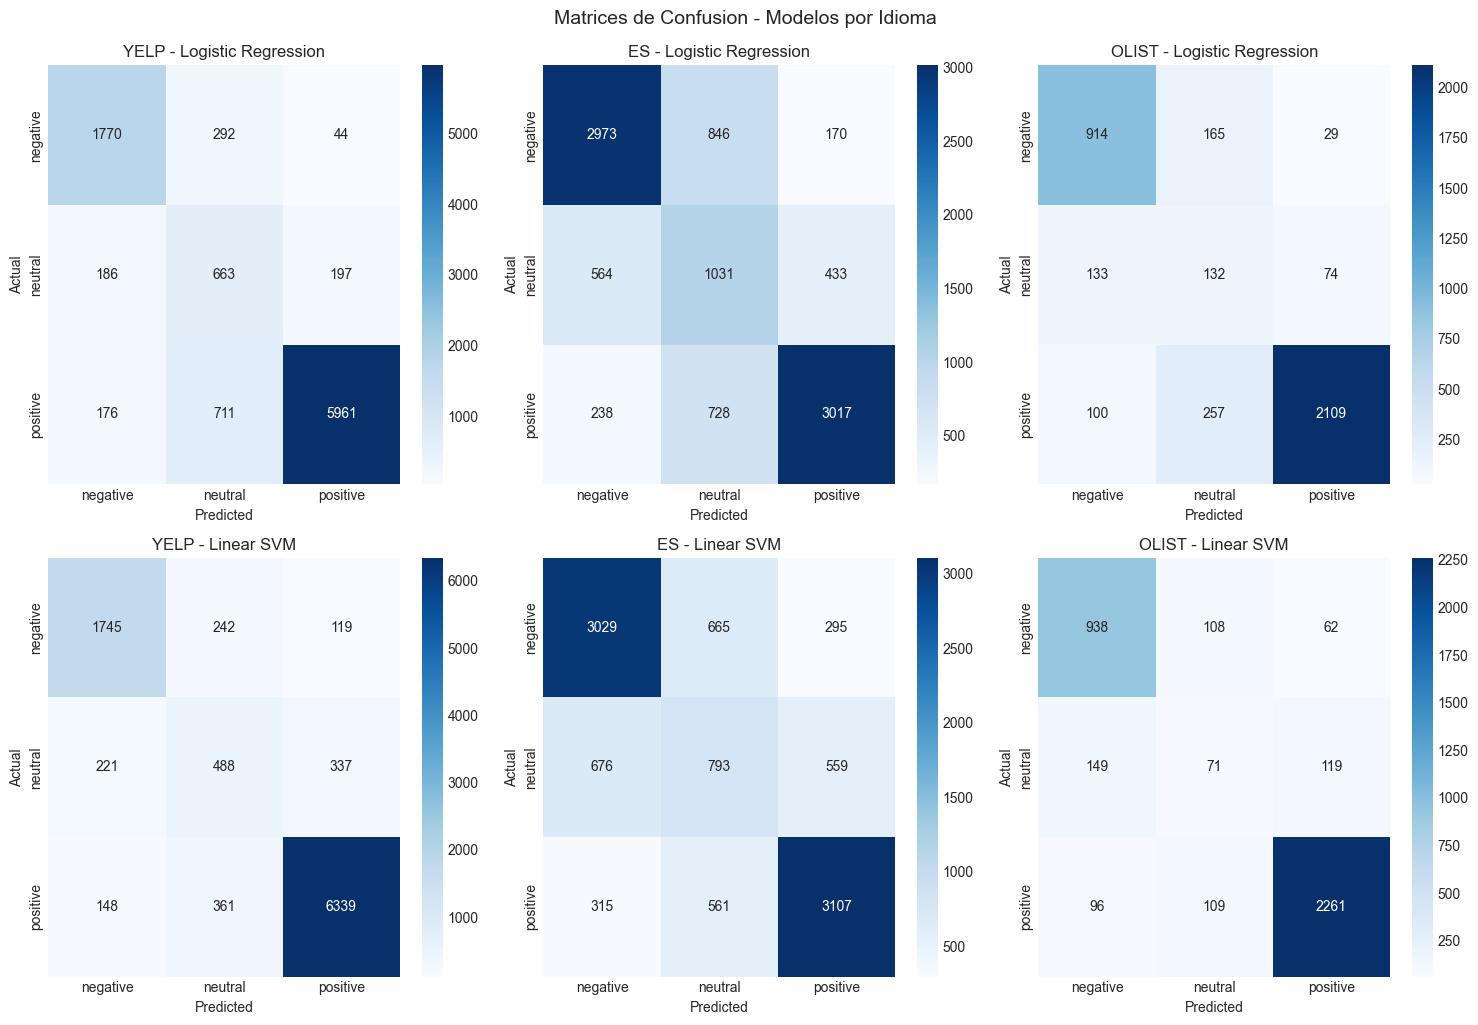

In [10]:
# Visualizar matrices de confusion por idioma
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, (dataset_name, results) in enumerate(results_by_language.items()):
    # Logistic
    plot_confusion_matrix(
        results['logistic']['y_test'],
        results['logistic']['y_pred'],
        f"{dataset_name.upper()} - Logistic Regression",
        ax=axes[0, idx]
    )
    
    # SVM
    plot_confusion_matrix(
        results['svm']['y_test'],
        results['svm']['y_pred'],
        f"{dataset_name.upper()} - Linear SVM",
        ax=axes[1, idx]
    )

plt.tight_layout()
plt.suptitle('Matrices de Confusion - Modelos por Idioma', y=1.02, fontsize=14)
plt.show()

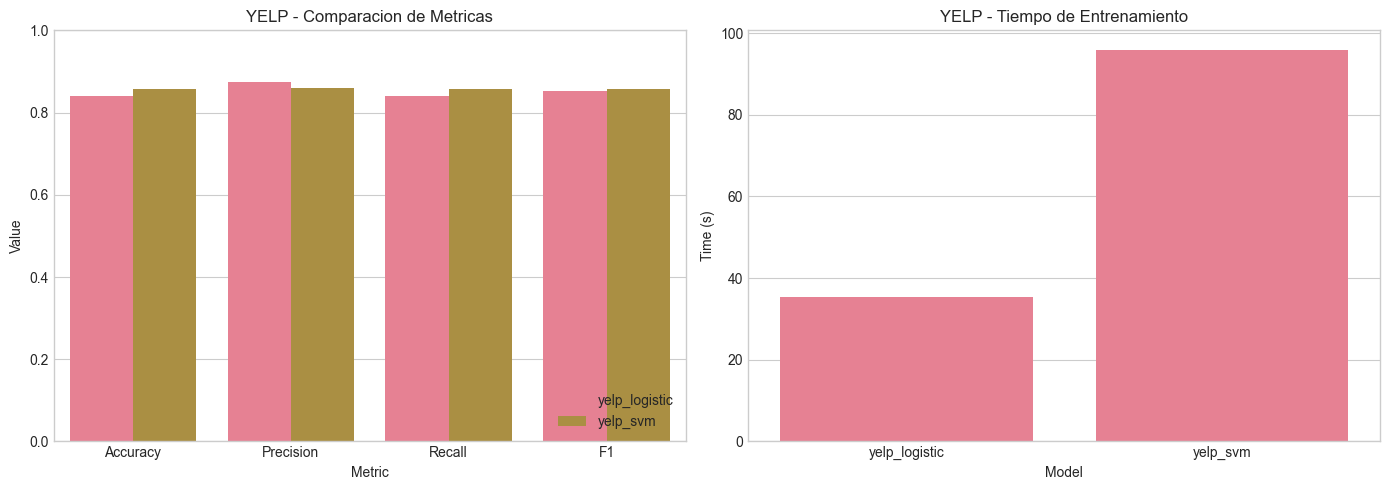

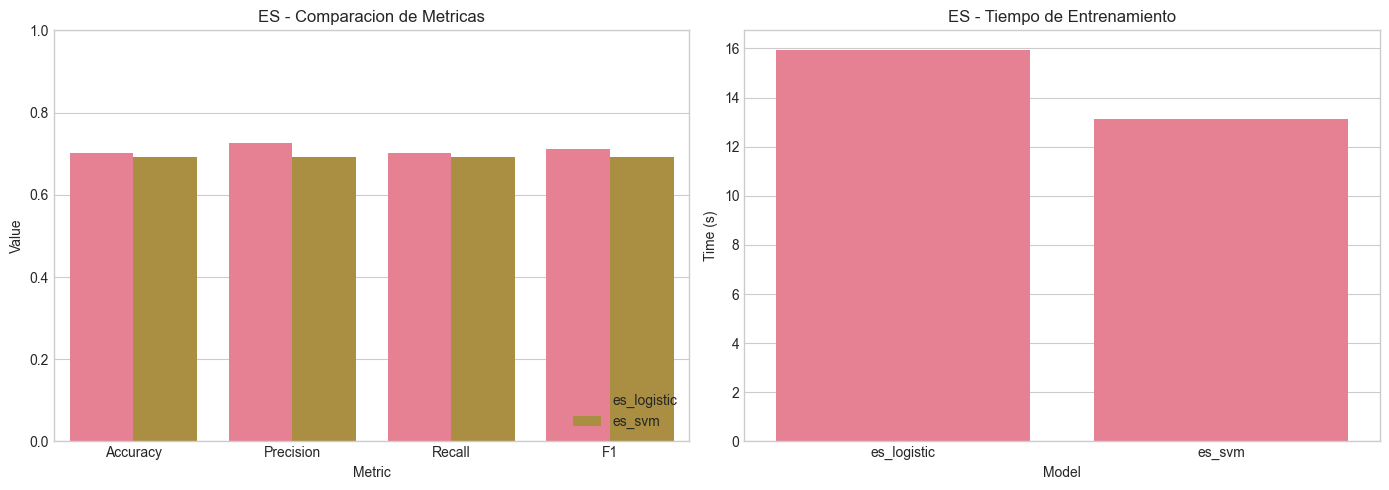

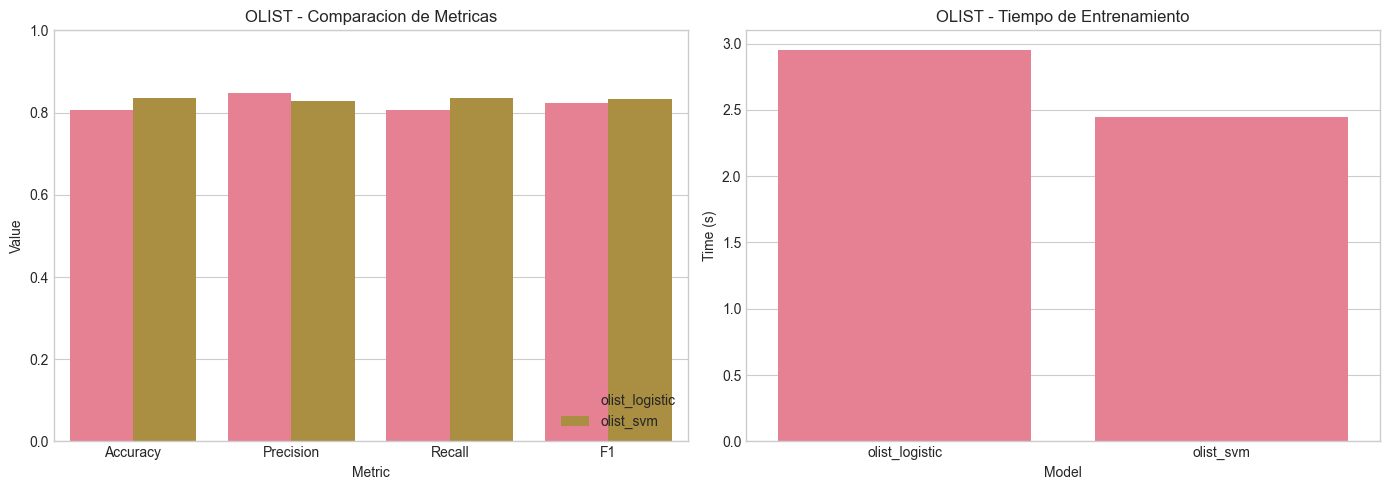

In [11]:
# Comparar metricas por dataset
for dataset_name, results in results_by_language.items():
    plot_metrics_comparison(
        [results['logistic'], results['svm']],
        f"{dataset_name.upper()}"
    )

## 5. Aproximacion 2: Modelo Unificado Multi-idioma

In [12]:
print("="*80)
print("APROXIMACION 2: MODELO UNIFICADO MULTI-IDIOMA")
print("="*80)

# Combinar todos los datasets
pdf_unified = pd.concat([pdf_yelp, pdf_es, pdf_olist], ignore_index=True)
print(f"\nTotal registros combinados: {len(pdf_unified):,}")
print(f"Distribucion por dataset: {pdf_unified['dataset'].value_counts().to_dict()}")
print(f"Distribucion por sentimiento: {pdf_unified['sentiment'].value_counts().to_dict()}")

APROXIMACION 2: MODELO UNIFICADO MULTI-IDIOMA

Total registros combinados: 119,563
Distribucion por dataset: {'es': 50000, 'yelp': 49998, 'olist': 19565}
Distribucion por sentimiento: {'positive': 66485, 'negative': 36013, 'neutral': 17065}


In [13]:
# Preparar datos unificados
X_unified = pdf_unified['text_clean'].values
y_unified = pdf_unified['sentiment'].values

# Split estratificado
X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(
    X_unified, y_unified, test_size=0.2, random_state=42, stratify=y_unified
)

print(f"Train size: {len(X_train_uni):,}, Test size: {len(X_test_uni):,}")

# Almacenar indices de test para analisis posterior
test_indices = train_test_split(
    range(len(pdf_unified)), test_size=0.2, random_state=42, stratify=y_unified
)[1]
pdf_unified_test = pdf_unified.iloc[test_indices].copy()

Train size: 95,650, Test size: 23,913


In [14]:
# Entrenar modelos unificados
results_unified = {}

# Logistic Regression unificado
result_lr_unified = train_and_evaluate(
    X_train_uni, X_test_uni, y_train_uni, y_test_uni,
    model_type='logistic',
    model_name='unified_logistic'
)
results_unified['logistic'] = result_lr_unified

# Linear SVM unificado
result_svm_unified = train_and_evaluate(
    X_train_uni, X_test_uni, y_train_uni, y_test_uni,
    model_type='svm',
    model_name='unified_svm'
)
results_unified['svm'] = result_svm_unified


Entrenando: unified_logistic (LOGISTIC)

Tiempo de entrenamiento: 59.00s
Accuracy: 0.7582
Precision (weighted): 0.8065
Recall (weighted): 0.7582
F1 Score (weighted): 0.7760

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.75      0.77      7203
     neutral       0.36      0.58      0.44      3413
    positive       0.93      0.81      0.86     13297

    accuracy                           0.76     23913
   macro avg       0.69      0.71      0.69     23913
weighted avg       0.81      0.76      0.78     23913


Entrenando: unified_svm (SVM)

Tiempo de entrenamiento: 56.11s
Accuracy: 0.7836
Precision (weighted): 0.7888
Recall (weighted): 0.7836
F1 Score (weighted): 0.7859

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.81      0.79      7203
     neutral       0.40      0.41      0.41      3413
    positive       0.90      0.87      0.88     13297

    accuracy   

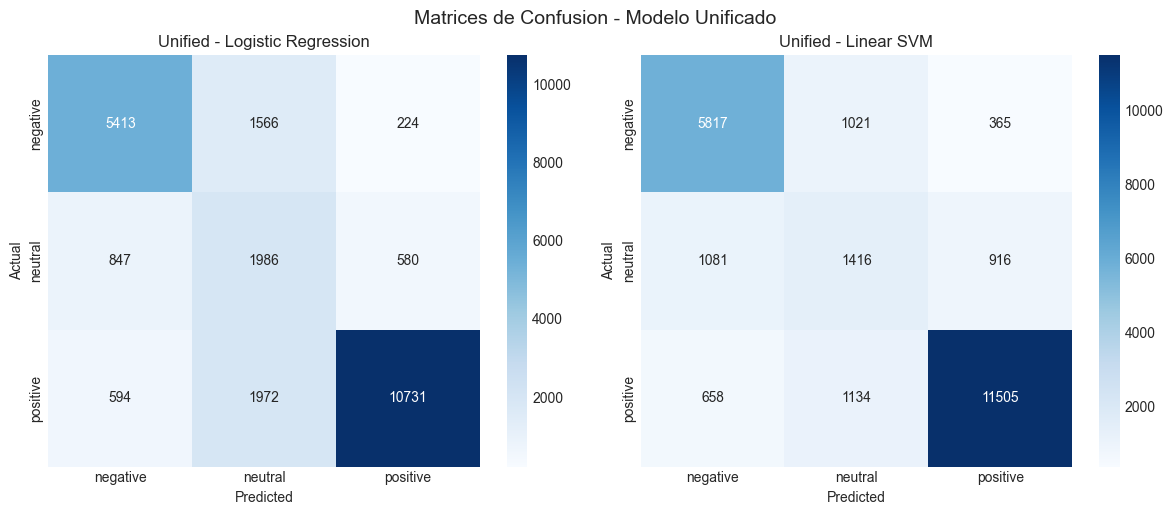

In [15]:
# Visualizar matrices de confusion modelo unificado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(
    results_unified['logistic']['y_test'],
    results_unified['logistic']['y_pred'],
    'Unified - Logistic Regression',
    ax=axes[0]
)

plot_confusion_matrix(
    results_unified['svm']['y_test'],
    results_unified['svm']['y_pred'],
    'Unified - Linear SVM',
    ax=axes[1]
)

plt.tight_layout()
plt.suptitle('Matrices de Confusion - Modelo Unificado', y=1.02, fontsize=14)
plt.show()

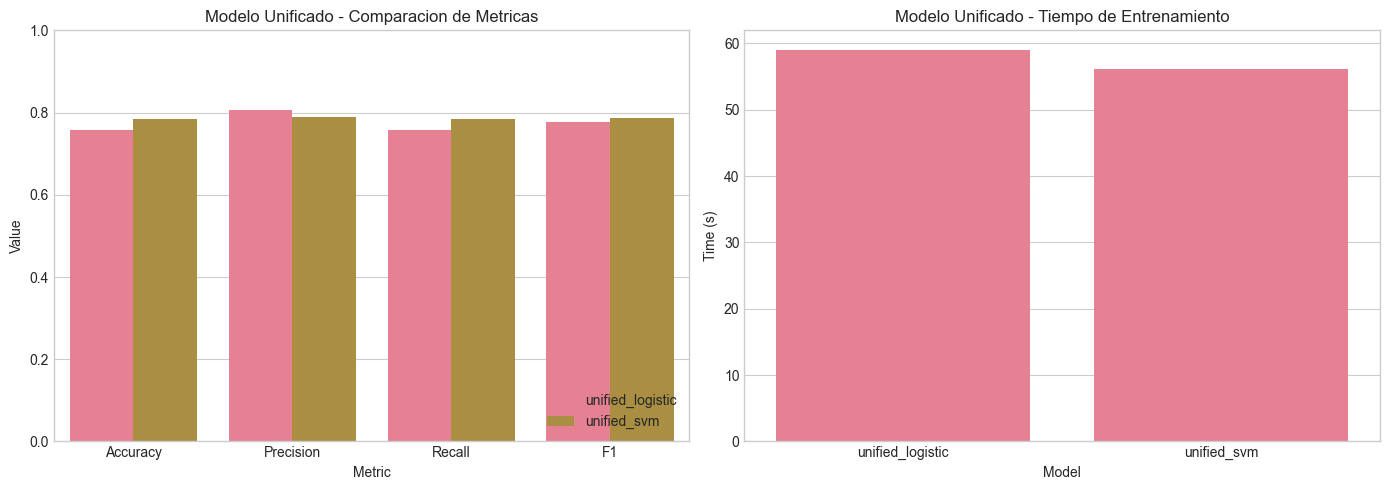

In [16]:
# Comparar metricas modelo unificado
plot_metrics_comparison(
    [results_unified['logistic'], results_unified['svm']],
    "Modelo Unificado"
)

In [17]:
# Analisis de rendimiento por idioma en modelo unificado
print("\nRendimiento del modelo unificado por idioma:")
print("="*60)

for model_type in ['logistic', 'svm']:
    pipeline = results_unified[model_type]['pipeline']
    
    print(f"\n{model_type.upper()}:")
    
    for dataset_name in ['yelp', 'es', 'olist']:
        # Filtrar test set por idioma
        mask = pdf_unified_test['dataset'] == dataset_name
        X_lang = pdf_unified_test[mask]['text_clean'].values
        y_lang = pdf_unified_test[mask]['sentiment'].values
        
        if len(X_lang) > 0:
            y_pred_lang = pipeline.predict(X_lang)
            acc = accuracy_score(y_lang, y_pred_lang)
            f1 = precision_recall_fscore_support(y_lang, y_pred_lang, average='weighted')[2]
            print(f"  {dataset_name.upper()}: Accuracy={acc:.4f}, F1={f1:.4f} (n={len(X_lang)})")


Rendimiento del modelo unificado por idioma:

LOGISTIC:
  YELP: Accuracy=0.8465, F1=0.8558 (n=9973)
  ES: Accuracy=0.6530, F1=0.6748 (n=10109)
  OLIST: Accuracy=0.8058, F1=0.8155 (n=3831)

SVM:
  YELP: Accuracy=0.8562, F1=0.8567 (n=9973)
  ES: Accuracy=0.6945, F1=0.6999 (n=10109)
  OLIST: Accuracy=0.8295, F1=0.8179 (n=3831)


## 6. Validacion con Corpus Anotado (ES)

In [18]:
# Cargar corpus anotado
annotated_path = project_root / 'data' / 'test' / 'es_annotated_reviews.csv'

if annotated_path.exists():
    df_annotated = pd.read_csv(annotated_path)
    print(f"Corpus anotado cargado: {len(df_annotated)} reviews")
    print(f"Distribucion de sentimiento:")
    print(df_annotated['sentiment_label'].value_counts())
else:
    print(f"Archivo no encontrado: {annotated_path}")
    df_annotated = None

Corpus anotado cargado: 300 reviews
Distribucion de sentimiento:
sentiment_label
positive    112
negative     96
neutral      92
Name: count, dtype: int64


In [19]:
if df_annotated is not None:
    # Preparar corpus anotado
    df_annotated['text_clean'] = df_annotated['text'].apply(clean_text)
    df_annotated = df_annotated[df_annotated['text_clean'].str.len() > 5]
    
    X_annotated = df_annotated['text_clean'].values
    y_annotated = df_annotated['sentiment_label'].values
    
    print(f"\nValidando modelos con corpus anotado...")
    print("="*60)
    
    # Validar modelo ES especifico
    if 'es' in results_by_language:
        for model_type in ['logistic', 'svm']:
            pipeline = results_by_language['es'][model_type]['pipeline']
            y_pred = pipeline.predict(X_annotated)
            
            acc = accuracy_score(y_annotated, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_annotated, y_pred, average='weighted'
            )
            
            print(f"\nModelo ES-{model_type.upper()} en corpus anotado:")
            print(f"  Accuracy: {acc:.4f}")
            print(f"  F1 (weighted): {f1:.4f}")
            print(f"\n{classification_report(y_annotated, y_pred)}")
    
    # Validar modelo unificado
    for model_type in ['logistic', 'svm']:
        pipeline = results_unified[model_type]['pipeline']
        y_pred = pipeline.predict(X_annotated)
        
        acc = accuracy_score(y_annotated, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_annotated, y_pred, average='weighted'
        )
        
        print(f"\nModelo UNIFIED-{model_type.upper()} en corpus anotado:")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1 (weighted): {f1:.4f}")
        print(f"\n{classification_report(y_annotated, y_pred)}")


Validando modelos con corpus anotado...

Modelo ES-LOGISTIC en corpus anotado:
  Accuracy: 0.7596
  F1 (weighted): 0.7424

              precision    recall  f1-score   support

    negative       0.74      0.89      0.81        88
     neutral       0.75      0.44      0.55        87
    positive       0.78      0.91      0.84       112

    accuracy                           0.76       287
   macro avg       0.76      0.74      0.73       287
weighted avg       0.76      0.76      0.74       287


Modelo ES-SVM en corpus anotado:
  Accuracy: 0.7561
  F1 (weighted): 0.7363

              precision    recall  f1-score   support

    negative       0.76      0.88      0.81        88
     neutral       0.73      0.41      0.53        87
    positive       0.76      0.93      0.84       112

    accuracy                           0.76       287
   macro avg       0.75      0.74      0.73       287
weighted avg       0.75      0.76      0.74       287


Modelo UNIFIED-LOGISTIC en corpus a

## 7. Cross-Validation para Seleccion de Modelo

In [20]:
print("Cross-Validation (5-fold) para seleccion de modelo")
print("="*60)

cv_results = []

# CV por idioma
for dataset_name, (language, pdf) in datasets.items():
    X = pdf['text_clean'].values
    y = pdf['sentiment'].values
    
    for model_type in ['logistic', 'svm']:
        pipeline = create_tfidf_pipeline(model_type)
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted', n_jobs=-1)
        
        cv_results.append({
            'Dataset': dataset_name,
            'Model': model_type,
            'F1_mean': scores.mean(),
            'F1_std': scores.std()
        })
        
        print(f"{dataset_name.upper()} - {model_type.upper()}: F1 = {scores.mean():.4f} (+/- {scores.std():.4f})")

# CV unificado
print("\nModelo Unificado:")
for model_type in ['logistic', 'svm']:
    pipeline = create_tfidf_pipeline(model_type)
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_unified, y_unified, cv=cv, scoring='f1_weighted', n_jobs=-1)
    
    cv_results.append({
        'Dataset': 'unified',
        'Model': model_type,
        'F1_mean': scores.mean(),
        'F1_std': scores.std()
    })
    
    print(f"UNIFIED - {model_type.upper()}: F1 = {scores.mean():.4f} (+/- {scores.std():.4f})")

Cross-Validation (5-fold) para seleccion de modelo
YELP - LOGISTIC: F1 = 0.8431 (+/- 0.0022)
YELP - SVM: F1 = 0.8496 (+/- 0.0018)
ES - LOGISTIC: F1 = 0.7135 (+/- 0.0030)
ES - SVM: F1 = 0.6974 (+/- 0.0036)
OLIST - LOGISTIC: F1 = 0.8217 (+/- 0.0044)
OLIST - SVM: F1 = 0.8253 (+/- 0.0021)

Modelo Unificado:
UNIFIED - LOGISTIC: F1 = 0.7767 (+/- 0.0021)
UNIFIED - SVM: F1 = 0.7847 (+/- 0.0015)


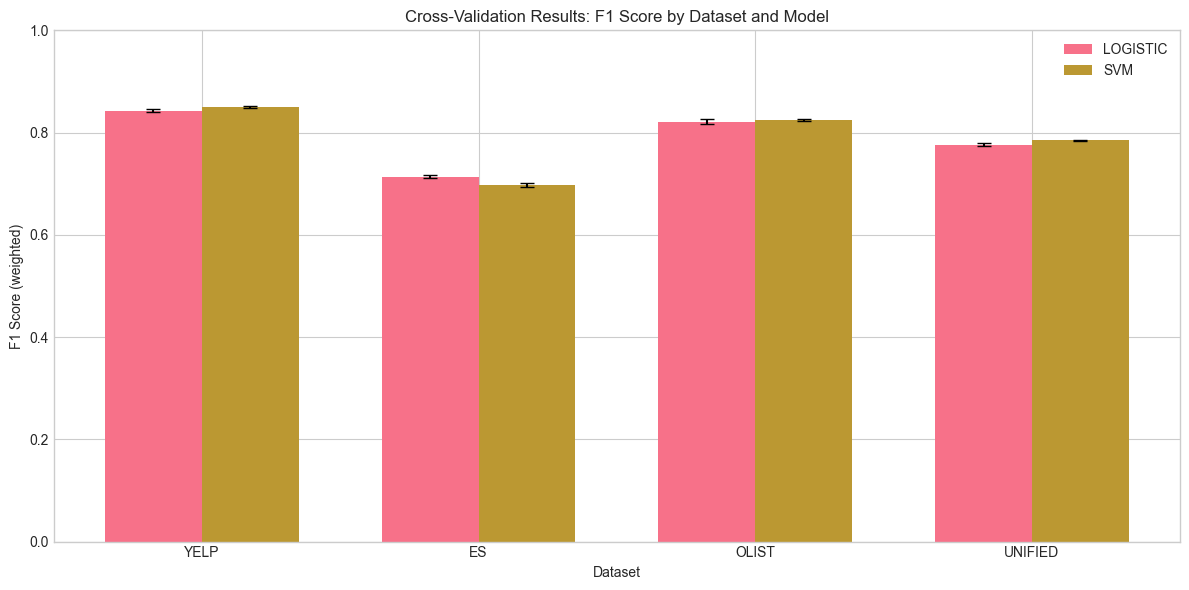

In [21]:
# Visualizar resultados de CV
df_cv = pd.DataFrame(cv_results)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_cv['Dataset'].unique()))
width = 0.35

for i, model_type in enumerate(['logistic', 'svm']):
    data = df_cv[df_cv['Model'] == model_type]
    bars = ax.bar(
        x + (i - 0.5) * width,
        data['F1_mean'],
        width,
        yerr=data['F1_std'],
        label=model_type.upper(),
        capsize=5
    )

ax.set_xlabel('Dataset')
ax.set_ylabel('F1 Score (weighted)')
ax.set_title('Cross-Validation Results: F1 Score by Dataset and Model')
ax.set_xticks(x)
ax.set_xticklabels([d.upper() for d in df_cv['Dataset'].unique()])
ax.legend()
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [22]:
# Recopilar todos los resultados
summary_data = []

# Modelos por idioma
for dataset_name, results in results_by_language.items():
    for model_type in ['logistic', 'svm']:
        r = results[model_type]
        summary_data.append({
            'Approach': 'By Language',
            'Dataset': dataset_name.upper(),
            'Model': model_type.upper(),
            'Accuracy': r['accuracy'],
            'Precision': r['precision'],
            'Recall': r['recall'],
            'F1': r['f1'],
            'Train Time (s)': r['train_time']
        })

# Modelo unificado
for model_type in ['logistic', 'svm']:
    r = results_unified[model_type]
    summary_data.append({
        'Approach': 'Unified',
        'Dataset': 'ALL',
        'Model': model_type.upper(),
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1'],
        'Train Time (s)': r['train_time']
    })

df_summary = pd.DataFrame(summary_data)
print("\nRESUMEN COMPARATIVO DE MODELOS")
print("="*80)
print(df_summary.to_string(index=False))


RESUMEN COMPARATIVO DE MODELOS
   Approach Dataset    Model  Accuracy  Precision   Recall       F1  Train Time (s)
By Language    YELP LOGISTIC  0.839400   0.874658 0.839400 0.852665       35.273617
By Language    YELP      SVM  0.857200   0.859471 0.857200 0.858304       95.845110
By Language      ES LOGISTIC  0.702100   0.726371 0.702100 0.711859       15.936757
By Language      ES      SVM  0.692900   0.692643 0.692900 0.692764       13.137138
By Language   OLIST LOGISTIC  0.806287   0.847142 0.806287 0.823390        2.951300
By Language   OLIST      SVM  0.835676   0.829370 0.835676 0.832130        2.443313
    Unified     ALL LOGISTIC  0.758165   0.806501 0.758165 0.776010       58.998614
    Unified     ALL      SVM  0.783591   0.788834 0.783591 0.785859       56.106261


In [26]:
df_summary

,Approach,Dataset,Model,Accuracy,Precision,Recall,F1,Train Time (s)
0,By Language,YELP,LOGISTIC,0.839400,0.874658,0.839400,0.852665,35.273617
1,By Language,YELP,SVM,0.857200,0.859471,0.857200,0.858304,95.845110
2,By Language,ES,LOGISTIC,0.702100,0.726371,0.702100,0.711859,15.936757
3,By Language,ES,SVM,0.692900,0.692643,0.692900,0.692764,13.137138
4,By Language,OLIST,LOGISTIC,0.806287,0.847142,0.806287,0.823390,2.951300
5,By Language,OLIST,SVM,0.835676,0.829370,0.835676,0.832130,2.443313
6,Unified,ALL,LOGISTIC,0.758165,0.806501,0.758165,0.776010,58.998614
7,Unified,ALL,SVM,0.783591,0.788834,0.783591,0.785859,56.106261


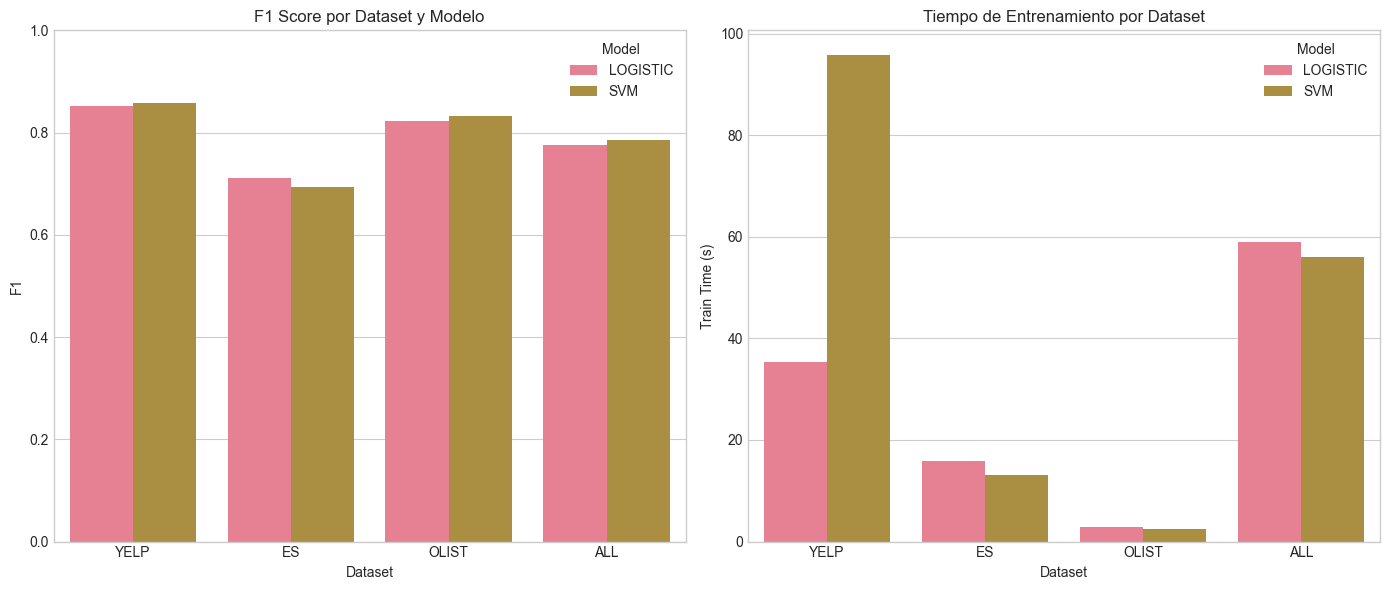

In [23]:
# Visualizacion final
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# F1 Score por aproximacion
sns.barplot(
    data=df_summary, x='Dataset', y='F1', hue='Model', ax=axes[0]
)
axes[0].set_title('F1 Score por Dataset y Modelo')
axes[0].set_ylim(0, 1)
axes[0].legend(title='Model')

# Tiempo de entrenamiento
sns.barplot(
    data=df_summary, x='Dataset', y='Train Time (s)', hue='Model', ax=axes[1]
)
axes[1].set_title('Tiempo de Entrenamiento por Dataset')
axes[1].legend(title='Model')

plt.tight_layout()
plt.show()

## 9. Seleccion del Mejor Modelo

In [27]:
# Determinar mejor modelo
print("\nSELECCION DEL MEJOR MODELO")
print("="*60)

# Mejor por F1
best_idx = df_summary['F1'].idxmax()
best_model = df_summary.loc[best_idx]

print(f"\nMejor modelo por F1 Score:")
print(f"  Approach: {best_model['Approach']}")
print(f"  Dataset: {best_model['Dataset']}")
print(f"  Model: {best_model['Model']}")
print(f"  F1 Score: {best_model['F1']:.4f}")
print(f"  Accuracy: {best_model['Accuracy']:.4f}")

# Mejor modelo unificado
unified_models = df_summary[df_summary['Approach'] == 'Unified']
best_unified_idx = unified_models['F1'].idxmax()
best_unified = df_summary.loc[best_unified_idx]

print(f"\nMejor modelo UNIFICADO:")
print(f"  Model: {best_unified['Model']}")
print(f"  F1 Score: {best_unified['F1']:.4f}")

# Recomendacion
print("\n" + "="*60)
print("RECOMENDACION:")
print("="*60)

avg_by_lang = df_summary[df_summary['Approach'] == 'By Language'].groupby('Model')['F1'].mean()
avg_unified = df_summary[df_summary['Approach'] == 'Unified'].groupby('Model')['F1'].mean()

print(f"\nPromedio F1 por idioma:")
for model, f1 in avg_by_lang.items():
    print(f"  {model}: {f1:.4f}")

print(f"\nF1 modelo unificado:")
for model, f1 in avg_unified.items():
    print(f"  {model}: {f1:.4f}")



SELECCION DEL MEJOR MODELO

Mejor modelo por F1 Score:
  Approach: By Language
  Dataset: YELP
  Model: SVM
  F1 Score: 0.8583
  Accuracy: 0.8572

Mejor modelo UNIFICADO:
  Model: SVM
  F1 Score: 0.7859

RECOMENDACION:

Promedio F1 por idioma:
  LOGISTIC: 0.7960
  SVM: 0.7944

F1 modelo unificado:
  LOGISTIC: 0.7760
  SVM: 0.7859


## 10. Guardar Modelos Entrenados

In [28]:
import joblib

# Directorio para modelos
models_dir = project_root / 'models' / 'sentiment'
models_dir.mkdir(parents=True, exist_ok=True)

print(f"Guardando modelos en: {models_dir}")

# Guardar modelos por idioma
for dataset_name, results in results_by_language.items():
    for model_type in ['logistic', 'svm']:
        model_path = models_dir / f'{dataset_name}_{model_type}_sentiment.joblib'
        joblib.dump(results[model_type]['pipeline'], model_path)
        print(f"  Guardado: {model_path.name}")

# Guardar modelos unificados
for model_type in ['logistic', 'svm']:
    model_path = models_dir / f'unified_{model_type}_sentiment.joblib'
    joblib.dump(results_unified[model_type]['pipeline'], model_path)
    print(f"  Guardado: {model_path.name}")

# Guardar resumen de resultados
summary_path = models_dir / 'model_comparison_results.csv'
df_summary.to_csv(summary_path, index=False)
print(f"\nResumen guardado: {summary_path.name}")

Guardando modelos en: c:\Users\Ozkr_\OneDrive - ESCUELA COLOMBIANA DE INGENIERIA JULIO GARAVITO\UAM\TFM\tfm-agents\models\sentiment
  Guardado: yelp_logistic_sentiment.joblib
  Guardado: yelp_svm_sentiment.joblib
  Guardado: es_logistic_sentiment.joblib
  Guardado: es_svm_sentiment.joblib
  Guardado: olist_logistic_sentiment.joblib
  Guardado: olist_svm_sentiment.joblib
  Guardado: unified_logistic_sentiment.joblib
  Guardado: unified_svm_sentiment.joblib

Resumen guardado: model_comparison_results.csv


## 11. Analisis de Tendencia en Reviews Neutrales

Uno de los objetivos clave de este TFM es analizar las reviews clasificadas como neutrales (3 estrellas) 
para detectar si tienen una tendencia polarizada hacia positivo o negativo. Esto es fundamental porque:

1. Las reviews de 3 estrellas son inherentemente ambiguas pero contienen informacion valiosa
2. Un cliente que da 3 estrellas puede estar "casi satisfecho" o "casi insatisfecho"
3. Detectar esta tendencia permite responder preguntas de negocio como: "Hacia donde se inclinan los indecisos?"

Para lograr esto, utilizo Logistic Regression porque ofrece probabilidades calibradas via predict_proba(),
a diferencia de SVM que solo proporciona distancias al hiperplano. La funcion analyze_neutral_trend()
examina las probabilidades de cada clase cuando la prediccion es neutral y determina la tendencia.

In [29]:
def analyze_neutral_trend(text: str, pipeline, threshold: float = 0.1) -> Dict[str, Any]:
    """
    Analiza una review y detecta tendencia en casos neutrales.
    
    Esta funcion es clave para el caso de uso de reviews de 3 estrellas:
    - Si el modelo predice 'neutral', examina las probabilidades de positive vs negative
    - Determina si el neutral "tira" hacia positivo o negativo
    - Permite responder preguntas como "que porcentaje de reviews neutrales tienden a positivo?"
    
    Args:
        text: Texto de la review (sin limpiar)
        pipeline: Pipeline de sklearn con Logistic Regression
        threshold: Diferencia minima entre prob_pos y prob_neg para declarar tendencia
        
    Returns:
        Dict con: predicted_label, probabilities, trend, trend_score, trend_description
    """
    # Limpiar texto
    text_clean = clean_text(text)
    
    # Obtener prediccion y probabilidades
    predicted_label = pipeline.predict([text_clean])[0]
    probabilities = pipeline.predict_proba([text_clean])[0]
    
    # Obtener orden de clases del modelo
    classes = pipeline.classes_
    class_to_idx = {c: i for i, c in enumerate(classes)}
    
    # Extraer probabilidades por clase
    prob_negative = probabilities[class_to_idx['negative']]
    prob_neutral = probabilities[class_to_idx['neutral']]
    prob_positive = probabilities[class_to_idx['positive']]
    
    # Calcular tendencia (diferencia entre positive y negative)
    trend_score = prob_positive - prob_negative
    
    # Determinar tendencia
    if predicted_label == 'neutral':
        if trend_score > threshold:
            trend = 'leaning_positive'
            trend_description = f"Neutral con tendencia POSITIVA (score: {trend_score:.3f})"
        elif trend_score < -threshold:
            trend = 'leaning_negative'
            trend_description = f"Neutral con tendencia NEGATIVA (score: {trend_score:.3f})"
        else:
            trend = 'truly_neutral'
            trend_description = f"Verdaderamente neutral (score: {trend_score:.3f})"
    else:
        trend = predicted_label
        trend_description = f"Clasificado como {predicted_label.upper()}"
    
    return {
        'text_preview': text[:80] + '...' if len(text) > 80 else text,
        'text_clean': text_clean,
        'predicted_label': predicted_label,
        'probabilities': {
            'negative': round(prob_negative, 4),
            'neutral': round(prob_neutral, 4),
            'positive': round(prob_positive, 4)
        },
        'trend': trend,
        'trend_score': round(trend_score, 4),
        'trend_description': trend_description
    }


def analyze_batch_neutral_trends(texts: List[str], pipeline, threshold: float = 0.1) -> pd.DataFrame:
    """
    Analiza un batch de reviews y genera estadisticas de tendencias.
    
    Util para responder preguntas de negocio como:
    - "Que porcentaje de reviews neutrales tienden a positivo?"
    - "Cual es la distribucion de tendencias en las reviews de 3 estrellas?"
    """
    results = []
    for text in texts:
        result = analyze_neutral_trend(text, pipeline, threshold)
        results.append(result)
    
    df_results = pd.DataFrame(results)
    return df_results


# Cargar modelo Logistic Regression (necesario para predict_proba)
model_path = models_dir / 'unified_logistic_sentiment.joblib'
if model_path.exists():
    loaded_model = joblib.load(model_path)
    print(f"Modelo cargado: {model_path.name}")
    print(f"Clases del modelo: {loaded_model.classes_}")
else:
    print(f"ERROR: Modelo no encontrado en {model_path}")

Modelo cargado: unified_logistic_sentiment.joblib
Clases del modelo: ['negative' 'neutral' 'positive']


### 11.1 Ejemplos de Analisis de Tendencias

A continuacion demuestro el funcionamiento de analyze_neutral_trend() con reviews de prueba 
en los 3 idiomas, mostrando como detecta la tendencia en casos neutrales.

In [30]:
# Ejemplos de analisis de tendencia con reviews de prueba
print("="*80)
print("EJEMPLOS DE ANALISIS DE TENDENCIA")
print("="*80)

# Reviews de prueba que representan diferentes casos
test_reviews_examples = [
    # Casos que podrian ser neutrales con tendencia positiva
    "The product is okay, works fine but nothing special. Delivery was fast though.",
    "El producto cumple su funcion, no es excelente pero tampoco malo. Precio justo.",
    "Produto razoavel, atendeu minhas expectativas basicas. Entrega no prazo.",
    
    # Casos que podrian ser neutrales con tendencia negativa
    "It's mediocre at best, had some issues but customer service helped. Not great.",
    "No esta mal pero esperaba mas calidad por el precio. Un poco decepcionado.",
    "Produto simples, qualidade poderia ser melhor. Embalagem chegou danificada.",
    
    # Casos claramente positivos/negativos para comparacion
    "Absolutely amazing! Best purchase I've made this year. Highly recommend!",
    "Terrible quality, broke after one week. Complete waste of money. Avoid!",
    "Excelente producto, supero todas mis expectativas. Lo volveria a comprar.",
]

print("\nAnalizando reviews de prueba...\n")

for i, review in enumerate(test_reviews_examples, 1):
    result = analyze_neutral_trend(review, loaded_model, threshold=0.1)
    
    print(f"Review {i}:")
    print(f"  Texto: {result['text_preview']}")
    print(f"  Prediccion: {result['predicted_label'].upper()}")
    print(f"  Probabilidades: neg={result['probabilities']['negative']:.3f}, "
          f"neu={result['probabilities']['neutral']:.3f}, "
          f"pos={result['probabilities']['positive']:.3f}")
    print(f"  Tendencia: {result['trend']} (score: {result['trend_score']:+.3f})")
    print(f"  >> {result['trend_description']}")
    print()

EJEMPLOS DE ANALISIS DE TENDENCIA

Analizando reviews de prueba...

Review 1:
  Texto: The product is okay, works fine but nothing special. Delivery was fast though.
  Prediccion: NEUTRAL
  Probabilidades: neg=0.020, neu=0.978, pos=0.002
  Tendencia: truly_neutral (score: -0.018)
  >> Verdaderamente neutral (score: -0.018)

Review 2:
  Texto: El producto cumple su funcion, no es excelente pero tampoco malo. Precio justo.
  Prediccion: NEUTRAL
  Probabilidades: neg=0.131, neu=0.568, pos=0.301
  Tendencia: leaning_positive (score: +0.170)
  >> Neutral con tendencia POSITIVA (score: 0.170)

Review 3:
  Texto: Produto razoavel, atendeu minhas expectativas basicas. Entrega no prazo.
  Prediccion: POSITIVE
  Probabilidades: neg=0.022, neu=0.057, pos=0.921
  Tendencia: positive (score: +0.899)
  >> Clasificado como POSITIVE

Review 4:
  Texto: It's mediocre at best, had some issues but customer service helped. Not great.
  Prediccion: NEGATIVE
  Probabilidades: neg=0.578, neu=0.379, pos=0.043

In [31]:
# ============================================================================
# ANALISIS DE TENDENCIAS CON DATOS REALES DE 3 ESTRELLAS
# ============================================================================
# Usamos los datasets que ya tenemos cargados para analizar reviews REALES

print("="*80)
print("ANALISIS DE TENDENCIAS EN REVIEWS REALES DE 3 ESTRELLAS")
print("="*80)

# Combinar los dataframes preparados
pdf_combined = pd.concat([pdf_yelp, pdf_es, pdf_olist], ignore_index=True)

# Filtrar reviews de 3 estrellas (las ambiguas/neutrales)
reviews_3_stars = pdf_combined[pdf_combined['stars'] == 3].copy()
print(f"\nTotal de reviews de 3 estrellas disponibles: {len(reviews_3_stars):,}")
print(f"\nDistribucion por dataset:")
print(reviews_3_stars['dataset'].value_counts())

# Muestra representativa para analisis
sample_size = min(1000, len(reviews_3_stars))
reviews_sample = reviews_3_stars.sample(n=sample_size, random_state=42)
print(f"\nAnalizando muestra de {sample_size} reviews de 3 estrellas...")

# Analizar tendencias
df_trends = analyze_batch_neutral_trends(
    reviews_sample['text_clean'].tolist(), 
    loaded_model, 
    threshold=0.1
)

# Agregar info del dataset
df_trends['dataset'] = reviews_sample['dataset'].values
df_trends['original_stars'] = reviews_sample['stars'].values

# Estadisticas de tendencias
print("\n" + "="*60)
print("DISTRIBUCION DE TENDENCIAS EN REVIEWS DE 3 ESTRELLAS")
print("="*60)

trend_counts = df_trends['trend'].value_counts()
trend_pcts = df_trends['trend'].value_counts(normalize=True) * 100

print("\nDistribucion global de tendencias:")
for trend, count in trend_counts.items():
    pct = trend_pcts[trend]
    print(f"  {trend:20s}: {count:4d} ({pct:5.1f}%)")

# Estadisticas del trend_score
print(f"\nEstadisticas del trend_score (prob_positive - prob_negative):")
print(f"  Media:   {df_trends['trend_score'].mean():+.4f}")
print(f"  Mediana: {df_trends['trend_score'].median():+.4f}")
print(f"  Std:     {df_trends['trend_score'].std():.4f}")
print(f"  Min:     {df_trends['trend_score'].min():+.4f}")
print(f"  Max:     {df_trends['trend_score'].max():+.4f}")

# Tendencias por dataset
print("\n" + "="*60)
print("TENDENCIAS POR DATASET")
print("="*60)
trend_by_dataset = pd.crosstab(df_trends['dataset'], df_trends['trend'], normalize='index') * 100
print(trend_by_dataset.round(1).to_string())

ANALISIS DE TENDENCIAS EN REVIEWS REALES DE 3 ESTRELLAS

Total de reviews de 3 estrellas disponibles: 17,065

Distribucion por dataset:
dataset
es       10140
yelp      5232
olist     1693
Name: count, dtype: int64

Analizando muestra de 1000 reviews de 3 estrellas...

DISTRIBUCION DE TENDENCIAS EN REVIEWS DE 3 ESTRELLAS

Distribucion global de tendencias:
  truly_neutral       :  280 ( 28.0%)
  leaning_negative    :  241 ( 24.1%)
  negative            :  189 ( 18.9%)
  leaning_positive    :  183 ( 18.3%)
  positive            :  107 ( 10.7%)

Estadisticas del trend_score (prob_positive - prob_negative):
  Media:   -0.0595
  Mediana: -0.0490
  Std:     0.3476
  Min:     -0.9431
  Max:     +0.9740

TENDENCIAS POR DATASET
trend    leaning_negative  leaning_positive  negative  positive  truly_neutral
dataset                                                                       
es                   28.3              15.4      21.3       7.8           27.1
olist                14.4        

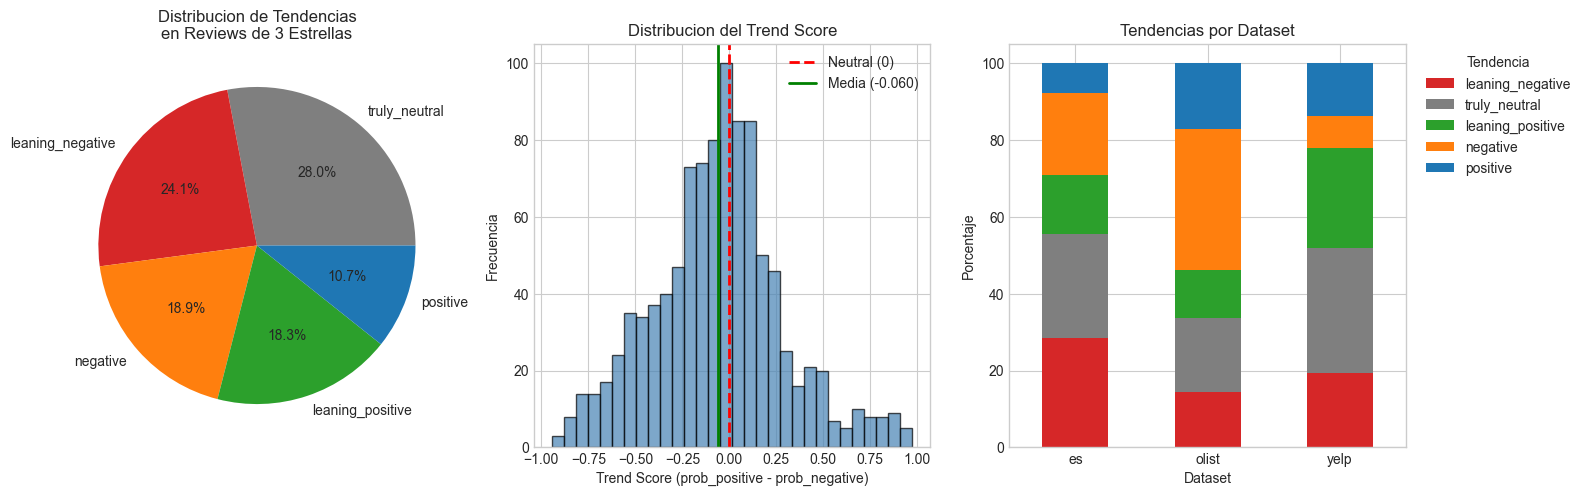


INSIGHT PRINCIPAL: Las reviews de 3 estrellas TIENDEN hacia NEGATIVO
(trend_score medio: -0.0595)


In [32]:
# Visualizacion de tendencias en reviews de 3 estrellas
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Pie chart de distribucion de tendencias
trend_colors = {
    'leaning_positive': '#2ca02c', 
    'truly_neutral': '#7f7f7f', 
    'leaning_negative': '#d62728', 
    'positive': '#1f77b4', 
    'negative': '#ff7f0e'
}
colors = [trend_colors.get(t, '#333333') for t in trend_counts.index]
axes[0].pie(trend_counts.values, labels=trend_counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Distribucion de Tendencias\nen Reviews de 3 Estrellas')

# 2. Histograma del trend_score
axes[1].hist(df_trends['trend_score'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
axes[1].axvline(x=df_trends['trend_score'].mean(), color='green', linestyle='-', 
                linewidth=2, label=f'Media ({df_trends["trend_score"].mean():.3f})')
axes[1].set_xlabel('Trend Score (prob_positive - prob_negative)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribucion del Trend Score')
axes[1].legend()

# 3. Tendencias por dataset (stacked bar)
trend_by_dataset_plot = trend_by_dataset.reindex(columns=['leaning_negative', 'truly_neutral', 'leaning_positive', 'negative', 'positive'], fill_value=0)
trend_by_dataset_plot.plot(
    kind='bar', 
    stacked=True, 
    ax=axes[2], 
    color=[trend_colors.get(c, '#333333') for c in trend_by_dataset_plot.columns]
)
axes[2].set_xlabel('Dataset')
axes[2].set_ylabel('Porcentaje')
axes[2].set_title('Tendencias por Dataset')
axes[2].tick_params(axis='x', rotation=0)
axes[2].legend(title='Tendencia', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Insight principal
mean_score = df_trends['trend_score'].mean()
if mean_score > 0.05:
    insight = "Las reviews de 3 estrellas TIENDEN hacia POSITIVO"
elif mean_score < -0.05:
    insight = "Las reviews de 3 estrellas TIENDEN hacia NEGATIVO"
else:
    insight = "Las reviews de 3 estrellas son VERDADERAMENTE NEUTRALES"

print(f"\n{'='*60}")
print(f"INSIGHT PRINCIPAL: {insight}")
print(f"(trend_score medio: {mean_score:+.4f})")
print(f"{'='*60}")

---

## Conclusiones y Decision Final

### Resumen de lo Conseguido

En este notebook he desarrollado y evaluado modelos de clasificacion de sentimiento para analizar reviews 
en tres idiomas (ingles, espanol y portugues). He comparado dos aproximaciones (modelos por idioma vs 
modelo unificado) y dos algoritmos (Logistic Regression vs Linear SVM).

Los resultados principales obtenidos son:

| Dataset | Logistic Regression F1 | Linear SVM F1 | Mejor |
|---------|------------------------|---------------|-------|
| YELP (ingles) | 0.8527 | 0.8583 | SVM |
| ES (espanol) | 0.7119 | 0.6928 | LR |
| OLIST (portugues) | 0.8234 | 0.8321 | SVM |
| Unificado | 0.7760 | 0.7859 | SVM |

### Decision: Modelo Unificado con Logistic Regression

Aunque SVM obtiene ligeramente mejores metricas en la mayoria de casos, he decidido usar el modelo 
unificado con Logistic Regression por las siguientes razones:

1. **Probabilidades calibradas**: Logistic Regression ofrece predict_proba() de forma nativa, lo cual es 
   esencial para la funcionalidad de deteccion de tendencias en reviews neutrales. SVM no proporciona 
   probabilidades directamente (requiere calibracion adicional que puede degradar el rendimiento).

2. **Caso de uso clave - Reviews de 3 estrellas**: El objetivo central de este TFM incluye analizar las 
   reviews ambiguas (3 estrellas) para detectar si tienden hacia positivo o negativo. Esto solo es 
   posible con las probabilidades de Logistic Regression.

3. **Diferencia marginal**: La diferencia de F1 entre LR y SVM es de apenas 0.01 en el modelo unificado 
   (0.776 vs 0.786). Esta diferencia no justifica perder la capacidad de analisis de tendencias.

4. **Simplicidad de integracion**: Aunque el sistema de agentes requiere indicar el dataset en cada 
   consulta, mantener un unico modelo simplifica el mantenimiento y reduce la complejidad de las tools.

### Importancia del Corpus Anotado

He utilizado un corpus de 300 reviews en espanol anotadas manualmente como validacion independiente. 
Este corpus es crucial porque:

- Proporciona una evaluacion objetiva fuera de la distribucion de entrenamiento
- Las etiquetas fueron asignadas por humanos, no derivadas automaticamente de las estrellas
- Permite detectar si el modelo generaliza bien a textos no vistos
- Los resultados (F1 ~0.75 en corpus anotado) confirman que el modelo es robusto

### Funcionalidad de Deteccion de Tendencias

He implementado la funcion analyze_neutral_trend() que permite:

- Clasificar reviews en positive/negative/neutral como antes
- Para reviews neutrales, determinar si tienden hacia positivo (leaning_positive), 
  negativo (leaning_negative), o son verdaderamente neutrales (truly_neutral)
- Cuantificar la tendencia con un trend_score (diferencia entre prob_positive y prob_negative)

Esto permite responder preguntas de negocio como:
- "Que porcentaje de reviews de 3 estrellas tienden hacia positivo?"
- "Hacia donde se inclinan los clientes indecisos?"
- "Cual es la distribucion de polaridad oculta en las reviews ambiguas?"

### Limitaciones Conocidas

- La clase neutral tiene recall mas bajo (~0.44-0.60) que positive/negative (~0.75-0.93)
- El dataset de espanol muestra rendimiento inferior (F1 ~0.70) comparado con ingles/portugues (~0.82-0.86)
- El corpus anotado es pequeno (300 reviews) - idealmente deberia ser mayor para validacion robusta

### Proximos Pasos

1. Integrar el modelo unified_logistic_sentiment.joblib como tool en el sistema de agentes
2. Implementar una tool get_sentiment_analysis() que use analyze_neutral_trend()
3. Crear una tool get_neutral_trends_distribution() para analisis agregado de tendencias
4. Considerar fine-tuning con mas datos de espanol para mejorar el rendimiento en ese idioma

---

**Fin del Notebook 05 - Modelos NLP para Analisis de Sentimiento**

Modelo seleccionado: `unified_logistic_sentiment.joblib`

Este modelo sera integrado en el sistema de agentes del TFM para responder consultas sobre:
- Distribucion de sentimientos en reviews
- Analisis de reviews de 3 estrellas y sus tendencias polarizadas
- Comparacion de sentimientos entre categorias/periodos de tiempo